In [40]:
import json
from pathlib import Path
from itertools import islice
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns

In [41]:
#Load json.
def load_dataset(path: Path):
    with open(path, 'r') as data_file:
        for line in data_file:
            yield json.loads(line)
        

In [42]:
#Import data
LuxuryB = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Luxury_Beauty/Luxury_Beauty.json'))
mLuxuryB = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Luxury_Beauty/meta_Luxury_Beauty.json'))
PrimePantry = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Prime_Pantry/Prime_Pantry.json'))
mPrimePantry = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Prime_Pantry/meta_Prime_Pantry.json'))

In [43]:
#I have just used these two datasets so far, you are free to use the others
LuxuryB = pd.DataFrame(LuxuryB)
mLuxuryB = pd.DataFrame(mLuxuryB)
Prime = pd.DataFrame(PrimePantry)
mPrime = pd.DataFrame(mPrimePantry)


In [44]:
#mPrime
(mPrime.brand.isnull().sum())/len(mPrime.brand)
len(mPrime.brand.unique())
len(mPrime.brand)
#isnull().sum()

10815

In [45]:
#Tidy the data for Luxury Beauty
LuxuryB = LuxuryB.loc[:, ['asin', 'overall', 'reviewTime','verified']]
#Only select the data where the verified purchase is Ture.
LuxuryBT = LuxuryB[LuxuryB['verified'] == True]
LuxuryBT.drop(['verified'], axis = 1, inplace = True)

mLuxuryB = mLuxuryB.loc[:, ['asin', 'title', 'price', 'main_cat']]
DF1 = pd.merge(LuxuryBT, mLuxuryB, how = "inner", on = "asin")
DF1['reviewTime'] = pd.to_datetime(DF1.reviewTime)

DF1

,asin,overall,reviewTime,title,price,main_cat
0,B00004U9V2,2.0,2010-06-15,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,$30.00,Luxury Beauty
1,B00004U9V2,2.0,2010-06-15,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,$30.00,Luxury Beauty
2,B00004U9V2,5.0,2010-01-07,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,$30.00,Luxury Beauty
3,B00004U9V2,5.0,2010-01-07,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,$30.00,Luxury Beauty
4,B00004U9V2,5.0,2018-04-18,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,$30.00,Luxury Beauty
...,...,...,...,...,...,...
527466,B01HIQCSBC,2.0,2016-09-20,"CND Shellac, Brick Knit",NaN,Luxury Beauty
527467,B01HIQCSBC,3.0,2016-09-15,"CND Shellac, Brick Knit",NaN,Luxury Beauty
527468,B01HIQCSBC,5.0,2016-08-08,"CND Shellac, Brick Knit",NaN,Luxury Beauty
527469,B01HJ2UY0W,1.0,2016-12-05,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz...",$76.00,Luxury Beauty


In [143]:
#sort_by_life = DF1.sort_values('title',ascending=False)
sort_by_life['title'][508402]

'var aPageStart = (new Date()).getTime();\nvar ue_t0=ue_t0||+new Date();\n\nwindow.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;\nif (window.ue_ihb === 1) {\n\nvar ue_csm = window,\n    ue_hob = +new Date();\n(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){if(1==window.ueinit)try{return b.apply(this,arguments)}catch(c){ueLogError(c,{attribution:a||"undefined",logLevel:"WARN"})}}}})(ue_csm);\n\n\n    var ue_err_chan = \'jserr-rw\';\n(function(d,e){function h(f,b){if(!(a.ec>a.mxe)&&f){a.ter.push(f);b=b||{};var c=f.logLevel||b.logLevel;c&&c!==k&&c!==m&&c!==n&&c!==p||a.ec++;c&&c!=k||a.ecf++;b.pageURL=""+(e.location?e.location.href:"");b.logLevel=c;b.attribution=f.attribution||b.attribution;a.erl.

In [46]:
#Tidy the data for Prime Pantry
Prime = Prime.loc[:, ['asin', 'overall', 'reviewTime','verified']]
#Only select the data where the verified purchase is Ture.
PrimeT = Prime[Prime['verified'] == True]
PrimeT.drop(['verified'], axis = 1, inplace = True)

mPrime = mPrime.loc[:, ['asin', 'title', 'price', 'brand', 'main_cat']]
DF2 = pd.merge(PrimeT, mPrime, how = "inner", on = "asin")
DF2['reviewTime'] = pd.to_datetime(DF2.reviewTime)
DF2

/Users/linxisarah/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,asin,overall,reviewTime,title,price,brand,main_cat
0,B0000DIWNZ,5.0,2014-12-14,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN
1,B0000DIWNZ,4.0,2014-11-20,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN
2,B0000DIWNZ,4.0,2014-10-11,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN
3,B0000DIWNZ,4.0,2014-08-10,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN
4,B0000DIWNZ,5.0,2014-07-14,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN
...,...,...,...,...,...,...,...
382686,B01HI8JVI8,5.0,2017-10-26,"Tostitos Salsa, Mild, 69 Ounce",$6.82,Tostitos,NaN
382687,B01HI8JVI8,5.0,2017-05-16,"Tostitos Salsa, Mild, 69 Ounce",$6.82,Tostitos,NaN
382688,B01HI8JVI8,5.0,2017-05-03,"Tostitos Salsa, Mild, 69 Ounce",$6.82,Tostitos,NaN
382689,B01HI8JVI8,5.0,2017-04-19,"Tostitos Salsa, Mild, 69 Ounce",$6.82,Tostitos,NaN


In [47]:
#Just a reminder here
if PrimeT.shape[0] < DF2.shape[0]:
    print("Some reviews are of products are not in the metadata")

Some reviews are of products are not in the metadata


In [48]:
#Set-up the time range
def add_first_review_time(data):
    min_review_time = min(data['reviewTime'])
    max_review_time = max(data['reviewTime'])
    data['firstReviewTime'] = min_review_time
    if ((max_review_time - min_review_time) / np.timedelta64(1, 'M')) >= 6:
        reviewed_by_at_least_six_motnths = True
    else:
        reviewed_by_at_least_six_motnths = False
    data['reviewedByAtLeastSixMotnths'] = reviewed_by_at_least_six_motnths
    return data

In [49]:
DF2 = DF2.groupby('asin').apply(add_first_review_time)

In [50]:
DF2['numMonthsSinceFirstReview'] = ((DF2['reviewTime'] - DF2['firstReviewTime']) / np.timedelta64(1, 'M')).astype(int)

In [52]:
#Sorted data
DF2.head(20)

,asin,overall,reviewTime,title,price,brand,main_cat,firstReviewTime,reviewedByAtLeastSixMotnths,numMonthsSinceFirstReview
0,B0000DIWNZ,5.0,2014-12-14,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,30
1,B0000DIWNZ,4.0,2014-11-20,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,29
2,B0000DIWNZ,4.0,2014-10-11,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,28
3,B0000DIWNZ,4.0,2014-08-10,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,26
4,B0000DIWNZ,5.0,2014-07-14,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,25
5,B0000DIWNZ,5.0,2013-06-19,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,12
6,B0000DIWNZ,5.0,2013-05-11,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,11
7,B0000DIWNZ,1.0,2012-05-27,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,0
8,B0000DIWNZ,5.0,2018-03-01,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,69
9,B0000DIWNZ,4.0,2018-02-26,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,69


In [53]:
#Select the products which have been reviewed more than 6 month and only take the data for the first 6 month.
DFx = DF2[(DF2['reviewedByAtLeastSixMotnths'] == True) & (DF2['numMonthsSinceFirstReview'] < 6)]
DFx

,asin,overall,reviewTime,title,price,brand,main_cat,firstReviewTime,reviewedByAtLeastSixMotnths,numMonthsSinceFirstReview
7,B0000DIWNZ,1.0,2012-05-27,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,0
18,B0000DIWNI,5.0,2007-08-29,"Saran Premium Plastic Wrap, 100 Sq Ft",NaN,Saran,NaN,2007-08-29,True,0
83,B0000GH6UG,5.0,2010-04-30,"Ibarra Mexican Chocolate, 19 oz",NaN,Ibarra,NaN,2010-04-30,True,0
96,B0001E1IN8,5.0,2011-05-22,"Castillo Habanero Hot Sauce Red, 5 oz",NaN,Castillo,NaN,2011-05-22,True,0
109,B00032E8XK,2.0,2009-08-13,"Chicken of the Sea, Solid White Albacore Tuna ...",$1.48,Chicken of the Sea,NaN,2009-08-13,True,0
...,...,...,...,...,...,...,...,...,...,...
382685,B01HI76EWA,5.0,2017-02-14,"KIND Bars, Dark Chocolate Chili Almond, Gluten...",$7.96,KIND,NaN,2017-02-14,True,0
382687,B01HI8JVI8,5.0,2017-05-16,"Tostitos Salsa, Mild, 69 Ounce",$6.82,Tostitos,NaN,2017-02-23,True,2
382688,B01HI8JVI8,5.0,2017-05-03,"Tostitos Salsa, Mild, 69 Ounce",$6.82,Tostitos,NaN,2017-02-23,True,2
382689,B01HI8JVI8,5.0,2017-04-19,"Tostitos Salsa, Mild, 69 Ounce",$6.82,Tostitos,NaN,2017-02-23,True,1


In [102]:
#Count the frequency of reviews in each month for each product
DF_Count = DFx.groupby(["brand", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
DF_Count

,brand,numMonthsSinceFirstReview,Count
0,18 Rabbits,0,12
1,18 Rabbits,1,4
2,18 Rabbits,2,1
3,18 Rabbits,3,2
4,18 Rabbits,4,6
...,...,...,...
7259,vitaminwater,1,12
7260,vitaminwater,2,6
7261,vitaminwater,3,11
7262,vitaminwater,4,7


In [103]:
#DF['reviewTime'][0] - DF['firstReviewTime'][0]

In [104]:
#Calculate the mean value of review of each month
DF_Count.loc[:, 'MonthSum'] = DF_Count.groupby(['numMonthsSinceFirstReview'])['Count'].transform(np.sum)
DF_Count.loc[:, 'Mean'] = DF_Count['MonthSum']/len(DF_Count.brand.unique())
DF_Count

,brand,numMonthsSinceFirstReview,Count,MonthSum,Mean
0,18 Rabbits,0,12,14846,8.921875
1,18 Rabbits,1,4,7296,4.384615
2,18 Rabbits,2,1,8693,5.224159
3,18 Rabbits,3,2,8784,5.278846
4,18 Rabbits,4,6,9590,5.763221
...,...,...,...,...,...
7259,vitaminwater,1,12,7296,4.384615
7260,vitaminwater,2,6,8693,5.224159
7261,vitaminwater,3,11,8784,5.278846
7262,vitaminwater,4,7,9590,5.763221


In [105]:
len(DF_Count.brand.unique())

1664

In [130]:
P1_D1 = DF_Count.pivot(index='numMonthsSinceFirstReview', columns='brand', values='Count')
P1_D1.reset_index(inplace=True)
P1_D2 = DF_Count[['numMonthsSinceFirstReview','Mean']]
P1_D2 = P1_D2.drop_duplicates(['numMonthsSinceFirstReview','Mean'])
P1_D2['Mean'] = round(P1_D2['Mean'], 1)
P1_D = pd.merge(P1_D2, P1_D1, how = "inner", on = "numMonthsSinceFirstReview")
P1_D = pd.DataFrame(P1_D)
P1_D.fillna(0, inplace=True)
P1_D

,numMonthsSinceFirstReview,Mean,18 Rabbits,3M,479 Degrees,5 Gum,5-Hour Energy,A&D,ACCO Brands,ACE,...,illy issimo,o.b.,purely elizabeth,resource,rhinocort,simplehuman,smartwater,thinkThin,vH essentials,vitaminwater
0,0,8.9,12.0,1.0,2.0,2.0,1.0,8.0,3.0,20.0,...,9.0,5.0,17.0,1.0,2.0,1.0,2.0,33.0,3.0,9.0
1,1,4.4,4.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,...,6.0,1.0,3.0,0.0,0.0,0.0,4.0,18.0,1.0,12.0
2,2,5.2,1.0,0.0,0.0,0.0,1.0,2.0,3.0,5.0,...,6.0,1.0,6.0,1.0,2.0,0.0,2.0,14.0,1.0,6.0
3,3,5.3,2.0,0.0,3.0,0.0,0.0,5.0,3.0,3.0,...,3.0,1.0,5.0,2.0,0.0,0.0,3.0,22.0,2.0,11.0
4,4,5.8,6.0,2.0,4.0,0.0,0.0,5.0,1.0,4.0,...,2.0,2.0,8.0,1.0,2.0,0.0,8.0,24.0,0.0,7.0
5,5,5.8,2.0,0.0,5.0,1.0,1.0,3.0,1.0,5.0,...,5.0,0.0,5.0,3.0,2.0,0.0,8.0,17.0,0.0,7.0


In [122]:
from matplotlib.lines import Line2D

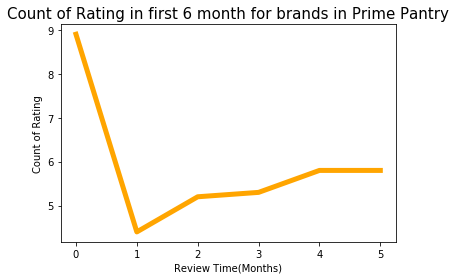

In [134]:

## Highlight the line with average value
plt.plot(P1_D['numMonthsSinceFirstReview'], P1_D['Mean'], marker='', color='orange', linewidth=5, alpha=1)

plt.title("Count of Rating in first 6 month for brands in Prime Pantry", 
              fontsize=15, fontweight=0)
plt.xlabel('Review Time(Months)')
plt.ylabel('Count of Rating')

plt.show()



(0, 20)

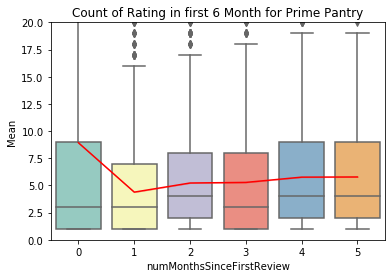

In [133]:
sns.boxplot(x="numMonthsSinceFirstReview", y="Count", data = DF_Count, palette="Set3", linewidth=1.5).set(
xlabel='Review Month', ylabel='Count of Rating', 
    title = "Count of Rating in first 6 Month for Prime Pantry")

sns.lineplot(y= DF_Count.Mean,x = DF_Count.numMonthsSinceFirstReview, color = "red")


plt.ylim(0,20)

In [ ]:
for column in P1_D.drop('numMonthsSinceFirstReview', axis=1):
    plt.plot(P1_D['numMonthsSinceFirstReview'], P1_D[column], '-.', 
             color='dimgrey', linewidth = 0.5, alpha = 0.2)

    

In [144]:
DFx

,asin,overall,reviewTime,title,price,brand,main_cat,firstReviewTime,reviewedByAtLeastSixMotnths,numMonthsSinceFirstReview
7,B0000DIWNZ,1.0,2012-05-27,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",NaN,Saran,NaN,2012-05-27,True,0
18,B0000DIWNI,5.0,2007-08-29,"Saran Premium Plastic Wrap, 100 Sq Ft",NaN,Saran,NaN,2007-08-29,True,0
83,B0000GH6UG,5.0,2010-04-30,"Ibarra Mexican Chocolate, 19 oz",NaN,Ibarra,NaN,2010-04-30,True,0
96,B0001E1IN8,5.0,2011-05-22,"Castillo Habanero Hot Sauce Red, 5 oz",NaN,Castillo,NaN,2011-05-22,True,0
109,B00032E8XK,2.0,2009-08-13,"Chicken of the Sea, Solid White Albacore Tuna ...",$1.48,Chicken of the Sea,NaN,2009-08-13,True,0
...,...,...,...,...,...,...,...,...,...,...
382685,B01HI76EWA,5.0,2017-02-14,"KIND Bars, Dark Chocolate Chili Almond, Gluten...",$7.96,KIND,NaN,2017-02-14,True,0
382687,B01HI8JVI8,5.0,2017-05-16,"Tostitos Salsa, Mild, 69 Ounce",$6.82,Tostitos,NaN,2017-02-23,True,2
382688,B01HI8JVI8,5.0,2017-05-03,"Tostitos Salsa, Mild, 69 Ounce",$6.82,Tostitos,NaN,2017-02-23,True,2
382689,B01HI8JVI8,5.0,2017-04-19,"Tostitos Salsa, Mild, 69 Ounce",$6.82,Tostitos,NaN,2017-02-23,True,1


In [170]:
DF_Price = DFx.groupby(["asin", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
DF_Price

,asin,numMonthsSinceFirstReview,Count
0,B00005BPJO,0,2
1,B00005BPJO,1,2
2,B0000DIWNI,0,1
3,B0000DIWNZ,0,1
4,B0000GH6UG,0,1
...,...,...,...
29544,B01HI776Y0,4,3
29545,B01HI776Y0,5,1
29546,B01HI8JVI8,0,1
29547,B01HI8JVI8,1,1


In [171]:
Price = DFx[['asin','price']]
Price = Price.drop_duplicates(['asin','price'])
DF_Price = pd.merge(Price, DF_Price, how = "inner", on = "asin")
DF_Price

,asin,price,numMonthsSinceFirstReview,Count
0,B0000DIWNZ,NaN,0,1
1,B0000DIWNI,NaN,0,1
2,B0000GH6UG,NaN,0,1
3,B0001E1IN8,NaN,0,1
4,B00032E8XK,$1.48,0,1
...,...,...,...,...
29544,B01HI76EWA,$7.96,4,1
29545,B01HI76EWA,$7.96,5,1
29546,B01HI8JVI8,$6.82,0,1
29547,B01HI8JVI8,$6.82,1,1


In [172]:
#DF_Price.describe()
DF_Price.Count.isnull().sum()

0

In [173]:
DF_Price.dropna(inplace = True) 

# new data frame with split value columns 
new = DF_Price["price"].str.split("$", n = 1, expand = True) 
  
# making separate first name column from new data frame 
DF_Price["price"]= new[1] 

# df display 
DF_Price

,asin,price,numMonthsSinceFirstReview,Count
4,B00032E8XK,1.48,0,1
8,B00099XO3W,1.69,0,1
9,B00099XO3W,1.69,2,1
10,B00099XO3W,1.69,3,3
11,B00099XO3W,1.69,4,1
...,...,...,...,...
29544,B01HI76EWA,7.96,4,1
29545,B01HI76EWA,7.96,5,1
29546,B01HI8JVI8,6.82,0,1
29547,B01HI8JVI8,6.82,1,1


In [178]:
DF_Price['price'] = pd.to_numeric(DF_Price['price'], errors='coerce')
DF_Price
DF_Price.describe()

,price,numMonthsSinceFirstReview,Count
count,22244.000000,22244.000000,22244.000000
mean,6.842208,2.204639,2.027198
std,6.411345,1.812112,1.651225
min,0.500000,0.000000,1.000000
25%,2.990000,0.000000,1.000000
50%,4.890000,2.000000,1.000000
75%,7.990000,4.000000,2.000000
max,112.990000,5.000000,43.000000


In [192]:
np.quantile(DF_Price['price'], 0.70)

7.12

In [193]:
DF_Price['Price_Range'] = np.where(DF_Price['price'] > np.quantile(DF_Price['price'], 0.75), 'high', 
         (np.where(DF_Price['price'] < np.quantile(DF_Price['price'], 0.25), 'low', 'medium')))
DF_Price

,asin,price,numMonthsSinceFirstReview,Count,Price_Range
4,B00032E8XK,1.48,0,1,low
8,B00099XO3W,1.69,0,1,low
9,B00099XO3W,1.69,2,1,low
10,B00099XO3W,1.69,3,3,low
11,B00099XO3W,1.69,4,1,low
...,...,...,...,...,...
29544,B01HI76EWA,7.96,4,1,medium
29545,B01HI76EWA,7.96,5,1,medium
29546,B01HI8JVI8,6.82,0,1,medium
29547,B01HI8JVI8,6.82,1,1,medium


(0, 10)

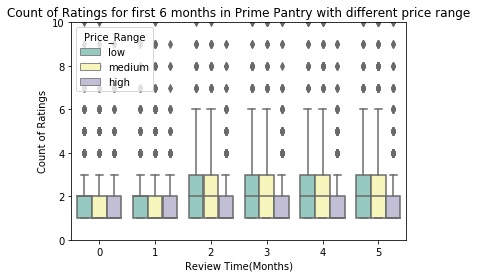

In [197]:
sns.boxplot(x="numMonthsSinceFirstReview", y="Count", hue="Price_Range", data=DF_Price, palette="Set3", linewidth=1.5).set(
xlabel='Review Time(Months)', ylabel='Count of Ratings', 
    title = "Count of Ratings for first 6 months in Prime Pantry with different price range")

plt.ylim(0,10)

In [195]:
DF_PriceRange = DF_Price.groupby(["Price_Range", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
DF_PriceRange




,Price_Range,numMonthsSinceFirstReview,Count
0,high,0,1675
1,high,1,698
2,high,2,771
3,high,3,771
4,high,4,826
5,high,5,805
6,low,0,1319
7,low,1,725
8,low,2,785
9,low,3,793


In [199]:
P2_D1 = DF_PriceRange.pivot(index='numMonthsSinceFirstReview', columns='Price_Range', values='Count')
P2_D1.reset_index(inplace=True)


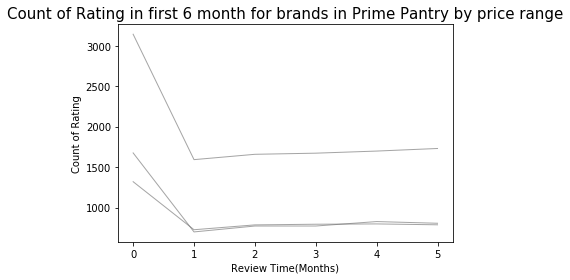

In [202]:
for column in P2_D1.drop('numMonthsSinceFirstReview', axis=1):
    plt.plot(P2_D1['numMonthsSinceFirstReview'], P2_D1[column], 
             color='dimgrey', linewidth = 1, alpha = 0.6)

plt.title("Count of Rating in first 6 month for brands in Prime Pantry by price range", 
              fontsize=15, fontweight=0)
plt.xlabel('Review Time(Months)')
plt.ylabel('Count of Rating')

plt.show()


(array([   0.,    0.,   10.,   36.,  246.,  141.,  295.,  350.,  358.,
         523.,  376.,  472.,  868.,  718., 1253.,  531.,  626.,  651.,
         668., 1137.,  319.,  408.,  495.,  381., 1076.,  258.,  357.,
         406.,  305.,  664.,  164.,  354.,  349.,  182.,  538.,   96.,
         206.,  248.,  206.,  427.,  122.,  126.,  169.,  114.,  311.,
          84.,  138.,  101.,   88.,  384.,   89.,   79.,   92.,  109.,
         188.,   29.,   48.,  127.,   48.,  202.,   41.,   82.,   79.,
          44.,  129.,   38.,   41.,   75.,   46.,  105.,   37.,   84.,
          53.,   51.,  117.,   40.,   31.,   32.,   22.,  140.,   31.,
          14.,   37.,   39.,  106.,   18.,   40.,   17.,   28.,   79.,
          20.,   19.,   22.,   26.,   54.,   14.,   12.,   12.,   10.,
          54.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8

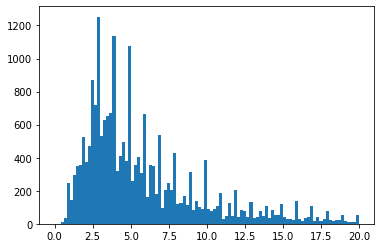

In [191]:
plt.hist(DF_Price['price'], bins=100, range=(0,20))

In [189]:
DF_Price.price.mode()

0    2.99
dtype: float64

(0, 5)

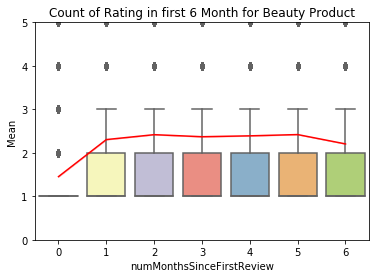

In [127]:
#Just some plots attempts...
##Boxplot
sns.boxplot(x="numMonthsSinceFirstReview", y="Count", data = DF_Count, palette="Set3", linewidth=1.5).set(
xlabel='Review Month', ylabel='Count of Rating', 
    title = "Count of Rating in first 6 Month for Beauty Product")

sns.lineplot(y= DF_Count.Mean,x = DF_Count.numMonthsSinceFirstReview, color = "red")


plt.ylim(0,5)


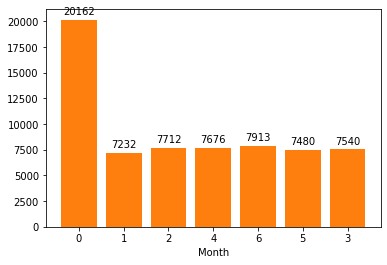

In [159]:
##Barchart

x = np.arange(7)
y = list(DF_Count.MonthSum.unique())

fig, ax = plt.subplots()

plt.bar(x, y)
plt.xlabel('Month')
plt.xticks(x, DF_Count.numMonthsSinceFirstReview.unique())



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(plt.bar(x, y))

plt.show()

In [154]:
A = pd.DataFrame(data = (DF_Count.MonthSum.unique(), DF_Count.numMonthsSinceFirstReview.unique())).T
A.sort_values(by = [1])

,0,1
0,20162,0
1,7232,1
2,7712,2
6,7540,3
3,7676,4
5,7480,5
4,7913,6


In [148]:
A = list(DF_Count.MonthSum.unique())
A.sort()
A

[7232, 7480, 7540, 7676, 7712, 7913, 20162]

In [92]:
df.groupby(["p", "q"]).size()

p  q
a  1    2
   2    1
b  1    1
s  3    2
dtype: int64

In [145]:
df = pd.DataFrame({'p':('a','a','b','a','s','s'), 'q':(1,2,1,1,3,3)})
df

,p,q
0,a,1
1,a,2
2,b,1
3,a,1
4,s,3
5,s,3


In [146]:
x = pd.DataFrame({'x':('5','4','3','5','7')})
df = pd.concat([df, x], axis=1, sort=False)

df = pd.DataFrame(df)

#df.brand.unique()

In [147]:
df

,p,q,x
0,a,1,5
1,a,2,4
2,b,1,3
3,a,1,5
4,s,3,7
5,s,3,NaN


In [100]:
DF_Count = DFx.groupby(["brand", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
DF_Count

array(['w', 'e', 'r', nan], dtype=object)

In [101]:
df_C = df.groupby(["x", "q",'']).size().reset_index(name="Count")
df_C

,x,q,Count
0,e,1,1
1,r,1,1
2,r,3,1
3,w,1,1
4,w,2,1


In [76]:
df = df.groupby(["p", "q"]).size().reset_index(name="F")
df

,p,q,F
0,a,1,2
1,a,2,1
2,b,1,1
3,s,3,2


In [77]:
df['mean'] = df.groupby(['q'])['F'].transform(np.mean)
df

,p,q,F,mean
0,a,1,2,1.5
1,a,2,1,1.0
2,b,1,1,1.5
3,s,3,2,2.0


In [78]:
df['sum'] = df.groupby(['q'])['F'].transform(np.sum)
df

,p,q,F,mean,sum
0,a,1,2,1.5,3
1,a,2,1,1.0,1
2,b,1,1,1.5,3
3,s,3,2,2.0,2


In [79]:
df['Amean'] = df['sum']/len(df.p.unique())
df
#len(df.p.unique())

,p,q,F,mean,sum,Amean
0,a,1,2,1.5,3,1.000000
1,a,2,1,1.0,1,0.333333
2,b,1,1,1.5,3,1.000000
3,s,3,2,2.0,2,0.666667


In [60]:
df['freq'] = df.groupby('p')['q'].transform(np.sum)
df

,p,q,freq
0,a,1,11
1,b,2,223
2,s,1,11
3,s,1,11
4,b,2,223
5,a,1,11
6,b,3,223
